In [1]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D,GlobalAveragePooling2D,Input
from keras.models import Model, Sequential, load_model

In [2]:
# Read the file tokens_clean.txt and store the cleaned captions in a dictionary
import json

content = None

with open ("data/textFiles/tokens_clean.txt", 'r') as file:
    content = file.read()

json_acceptable_string = content.replace("'", "\"")
content = json.loads(json_acceptable_string)

In [3]:
print(type(content))

<class 'dict'>


In [3]:
#Iterate over the captions word by word, and append each word to total_words
total_words = []

for key in content.keys():
    for caption in content[key]:
        for i in caption.split():
            total_words.append(i)

print("Total Words = %d" %len(total_words))

Total Words = 1955246


In [4]:
# Compute the frequency of occurrence of each word, and store it in a dictionary of word-freq
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

print("Number of unique words = " + str(len(freq_cnt.keys())))

Number of unique words = 18079


In [5]:
# Store the word-freq pairs (from the dictionary freq_cnt) in a list, sorted in decreasing order of frequency
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

In [6]:
threshold = 10

#Filter off those words whose frequency of occurrence in less than threshold
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
# Store these common words in total_words
total_words = [x[0] for x in sorted_freq_cnt]

print("Number of common unique words = " + str(len(total_words)))

Number of common unique words = 5136


PREPARE TRAIN AND TEST DATA

In [7]:
# Read training and testing image names

train_file_data = ""
test_file_data = ""

with open ("data/textFiles/flickr30k_train.txt", 'r') as file:
    train_file_data = file.read()

with open ("data/textFiles/flickr30k_test.txt", 'r') as file:
    test_file_data = file.read()

In [8]:
# Obtain a list of train and test images
train_data = [img_file_name for img_file_name in train_file_data.split("\n")[:-1]]
test_data = [img_file_name for img_file_name in test_file_data.split("\n")[:-1]]

# Obtain image ID from image file name
train_data = [image.split(".")[0] for image in train_data]
test_data = [image.split(".")[0] for image in test_data]

In [10]:
train_data[:5]

['1000092795', '10002456', '1000268201', '1000344755', '1000366164']

In [9]:
# For each imageID in train_data, store its captions in a dictionary 

train_content = {}

for imageID in train_data:
    train_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = "startseq " + caption + " endseq"
        train_content[imageID].append(cap_to_append)

In [11]:
train_content['1001896054']

['startseq a man with reflective safety clothes and ear protection drives a john deere tractor on a road  endseq',
 'startseq john deere tractors cruises down a street while the driver wears easy to see clothing  endseq',
 'startseq a man in a neon green and orange uniform is driving on a green tractor  endseq',
 'startseq a man in a tractor wearing headphones driving down a paved street  endseq',
 'startseq a man driving a john deere tractor on a main road in the country  endseq']

EXTRACT FEATURES FROM IMAGES USING RESNET50 ARCHIECTURE

In [10]:


model = ResNet50(weights = 'imagenet', input_shape = (224, 224, 3))

In [13]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [11]:
from keras.models import Model
model_new = Model (model.input, model.layers[-2].output)

In [12]:
from keras.preprocessing import image
import numpy as np

def preprocess_image (img):
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)

    # Convert 3D tensor to a 4D tendor
    img = np.expand_dims(img, axis=0)

    #Normalize image accoring to ResNet50 requirement
    img = preprocess_input(img)

    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


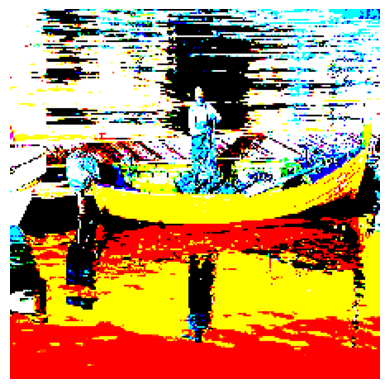

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

img = preprocess_image("data/Images/4376178.jpg")
print(img.shape)
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [14]:
# A wrapper function, which inputs an image and returns its encoding (feature vector)
def encode_image (img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)

    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [15]:
from time import time

train_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (train_data):
    image_path = "data/Images/" + imageID + ".jpg"
    
    train_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "sec")

1/1 [==============================] - 1s 1s/step
Encoding in progress... STEP 0
1/1 [==============================] - 0s 106ms/step
Encoding in progress... STEP 100
1/1 [==============================] - 0s 109ms/step
Encoding in progress... STEP 200
1/1 [==============================] - 0s 128ms/step
Encoding in progress... STEP 300
1/1 [==============================] - 0s 118ms/step
Encoding in progress... STEP 400
1/1 [==============================] - 0s 112ms/step
Encoding in progress... STEP 500
1/1 [==============================] - 0s 155ms/step
Encoding in progress... STEP 600
1/1 [==============================] - 0s 136ms/step
Encoding in progress... STEP 700
1/1 [==============================] - 0s 112ms/step
Encoding in progress... STEP 800
1/1 [==============================] - 0s 114ms/step
Encoding in progress... STEP 900
1/1 [==============================] - 0s 119ms/step
Encoding in progress... STEP 1000
1/1 [==============================] - 0s 146ms/step
Encod

In [19]:
import pickle

with open("encoded_train_features.pkl", "wb") as file:
    pickle.dump(train_encoding, file)

In [15]:
test_encoding = {}
# Create a dictionary of iamgeID and its feature vector
from time import time
start_time = time()
for index, imageID in enumerate (test_data):
    image_path = "data/Images/" + imageID + ".jpg"
    
    test_encoding[imageID] = encode_image(image_path)

    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "s")

1/1 [==============================] - 1s 1s/step
Encoding in progress... STEP 0
1/1 [==============================] - 0s 113ms/step
Encoding in progress... STEP 100
1/1 [==============================] - 0s 106ms/step
Encoding in progress... STEP 200
1/1 [==============================] - 0s 109ms/step
Encoding in progress... STEP 300
1/1 [==============================] - 0s 117ms/step
Encoding in progress... STEP 400
1/1 [==============================] - 0s 113ms/step
Encoding in progress... STEP 500
1/1 [==============================] - 0s 115ms/step
Encoding in progress... STEP 600
1/1 [==============================] - 0s 112ms/step
Encoding in progress... STEP 700
1/1 [==============================] - 0s 120ms/step
Encoding in progress... STEP 800
1/1 [==============================] - 0s 116ms/step
Encoding in progress... STEP 900
1/1 [==============================] - 0s 116ms/step
Total time taken: 164.2930371761322 s


In [16]:
import pickle
with open("encoded_test_features.pkl", "wb") as file:
    pickle.dump(test_encoding, file)

PREPROCESS THE CAPTIONS

In [17]:
word_to_index = {}
index_to_word = {}

for i, word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [18]:
print(len(index_to_word))

5136


In [24]:
print(index_to_word[5])
print(word_to_index['is'])

and
7


In [19]:
index_to_word[5137] = 'startseq'
word_to_index['startseq'] = 5137

index_to_word[5138] = 'endseq'
word_to_index['endseq'] = 5138

VOCAB_SIZE = len(word_to_index) + 1

In [26]:
print(VOCAB_SIZE)

5139


In [20]:
import pickle
with open("data/textFiles/word_to_idx.pkl", "wb") as file:
    pickle.dump(word_to_index, file)

In [21]:
with open("data/textFiles/idx_to_word.pkl", "wb") as file:
    pickle.dump(index_to_word, file)

In [22]:
max_len = 0

for cap_list in train_content.keys():
    for caption in train_content[cap_list]:
        max_len = max(max_len, len(caption.split()))

In [30]:
print(max_len)

80


In [26]:
# Word Embeddings
file = open("glove.6B.50d.txt",encoding='utf8')

In [27]:
# Create a mapping from word to embedding
embeddings_index = {}

for line in file:
    values = line.split()

    word = values[0]
    coefs = np.array (values[1:], dtype='float')
    embeddings_index[word] = coefs

file.close()

In [28]:
embeddings_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [29]:
embedding_dim = 50

embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))

for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [35]:
embedding_matrix.shape

(5139, 50)

DEFINE MODEL ARCHITECTURE

In [30]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM

inp_img_features = Input(shape=(2048,))

inp_img1 = Dropout(0.3)(inp_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [31]:

inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=VOCAB_SIZE, output_dim=50, mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
# inp_cap3 captures the entire sentence that has been generated till now

In [32]:
from keras.layers import add

decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

# Combined model
model = Model (inputs=[inp_img_features, inp_cap], outputs=outputs)

In [39]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 80, 50)       256950      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [33]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [34]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [35]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def data_generator (train_content, train_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for imageID, cap_list in train_content.items():
            n += 1

            image = train_encoding [imageID]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range (1, len(idx_seq)):
                    xi = idx_seq[0 : i] # The input sequence of words
                    yi = idx_seq[i] # The next word that needs to be predicted

                    # Add a padding of zeros 
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0] # Take the first row only, since this method inputs & returns a 2D array
                    # Convert the expected word to One Hot vector notation
                    yi = to_categorical([yi], num_classes=VOCAB_SIZE)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]
                    
                    X1, X2, y = [], [], []
                    n=0

TRAIN THE MODEL

In [36]:
epochs = 15
batch_size = 5
steps = len(train_content)//batch_size

In [45]:
for i in range(epochs):
    # Create an instance of the generator
    generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
    model.fit_generator(generator, steps_per_epoch=steps)
    model.save('model_' + str(i) + '.h5')

Epoch 1/1
5800/5800 [==============================] - 4879s 841ms/step - loss: 3.8658
Epoch 1/1
5800/5800 [==============================] - 4925s 849ms/step - loss: 3.3300
Epoch 1/1
5800/5800 [==============================] - 4944s 852ms/step - loss: 3.1881
Epoch 1/1
5800/5800 [==============================] - 4951s 854ms/step - loss: 3.1141
Epoch 1/1
5800/5800 [==============================] - 4956s 854ms/step - loss: 3.0679
Epoch 1/1
5800/5800 [==============================] - 4960s 855ms/step - loss: 3.0363
Epoch 1/1
5800/5800 [==============================] - 4952s 854ms/step - loss: 3.0136
Epoch 1/1
5800/5800 [==============================] - 4958s 855ms/step - loss: 2.9966
Epoch 1/1
5800/5800 [==============================] - 4951s 854ms/step - loss: 2.9813
Epoch 1/1
5800/5800 [==============================] - 4954s 854ms/step - loss: 2.9706
Epoch 1/1
5800/5800 [==============================] - 4939s 852ms/step - loss: 2.9625
Epoch 1/1
5800/5800 [======================

In [37]:
model.load_weights('./model_checkpoints/model_14.h5')

In [38]:
images = './data/Images/'

In [39]:
from pickle import dump, load
with open("./encoded_test_features.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [40]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [41]:
test_content = {}

for imageID in test_data:
    test_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = caption
        test_content[imageID].append(cap_to_append)

In [42]:
x = 0
pic = list(encoding_test.keys())[x]
test_content[pic]

['the man with pierced ears is wearing glasses and an orange hat ',
 'a man with glasses is wearing a beer can crocheted hat ',
 'a man with gauges and glasses is wearing a blitz hat ',
 'a man in an orange hat starring at something ',
 'a man wears an orange hat and glasses ']

102617084
Greedy Search Caption: a group of people are walking down a snowy path

Reference 1: ['five snowmobile riders all wearing helmets and goggles line up in a snowy clearing in a forest in front of their snowmobiles they are all wearing black snow pants and from left to right they are wearing a black coat white coat red coat blue coat and black coat ', 'five people wearing winter jackets and helmets stand in the snow with snowmobiles in the background ', 'five people wearing winter clothing helmets and ski goggles stand outside in the snow ', 'a group of snowmobile riders gather in the snow ', 'group gathered to go snowmobiling ']

BLEU-1: 0.738


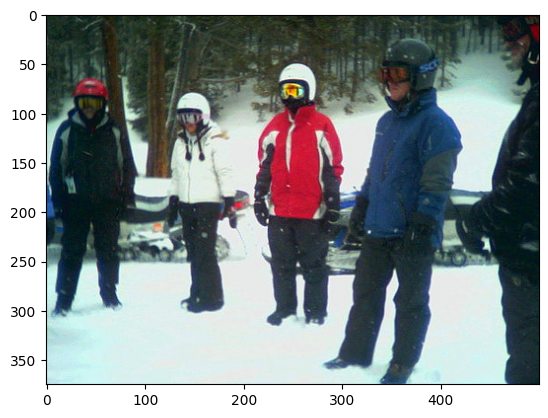

In [43]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

x = 3
pic = list(encoding_test.keys())[x]
test_content[pic]


reference = test_content[pic]
#pic = list(encoding_test.keys())[1]
print(pic)
img = 'twodogs.jpg'
e = encoding_test[pic].reshape(1,2048)
#image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
#x=plt.imread(img)
plt.imshow(x)
# plt.show()
caption = greedySearch(e)
print("Greedy Search Caption:",caption)
print()
print('Reference 1:',reference)

print()
print('BLEU-1:', round(sentence_bleu(reference, caption),3))

PERFORMANCE OF MODEL ON TESTING DATA

In [44]:
pics = list(encoding_test.keys())

In [45]:
acc = 0
for i in range(len(pics)):
    reference = test_content[pics[i]]
    e = encoding_test[pics[i]].reshape(1,2048)
    caption = greedySearch(e)
    acc += round(sentence_bleu(reference, caption),3)

In [46]:
print(acc/1000)

0.5639350000000002


PERFORMANCE OF MODEL ON VALIDATION DATA 

In [47]:
val_file_data = ""

with open ("data/textFiles/flickr30k_val.txt", 'r') as file:
    val_file_data = file.read()

In [48]:
val_data = [img_file_name for img_file_name in val_file_data.split("\n")[:-1]]
print(val_data)

val_data = [image.split(".")[0] for image in val_data]
print(val_data)

['1018148011.jpg', '1029450589.jpg', '1029737941.jpg', '103205630.jpg', '10350842.jpg', '1054620089.jpg', '1056873310.jpg', '1072439304.jpg', '1073444492.jpg', '1092437557.jpg', '109671650.jpg', '109738763.jpg', '109982467.jpg', '110269384.jpg', '1107507919.jpg', '112243673.jpg', '1124448967.jpg', '1126137905.jpg', '1128874064.jpg', '1130017585.jpg', '1141643526.jpg', '1141718391.jpg', '1150429218.jpg', '1155138244.jpg', '116569042.jpg', '1206506157.jpg', '120764850.jpg', '121556607.jpg', '1215804065.jpg', '123244147.jpg', '1235099089.jpg', '123866385.jpg', '126042604.jpg', '1277949368.jpg', '128452798.jpg', '1296770308.jpg', '1306755031.jpg', '1335877186.jpg', '1341787777.jpg', '1343426964.jpg', '134642833.jpg', '1348517311.jpg', '134857559.jpg', '1348947380.jpg', '1355945307.jpg', '135608578.jpg', '1358398144.jpg', '135980645.jpg', '1361790462.jpg', '1363843090.jpg', '1368338041.jpg', '136886677.jpg', '1389264266.jpg', '1393205795.jpg', '1394319096.jpg', '1405665934.jpg', '1409723496

In [49]:
from time import time
val_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (val_data):
    image_path = "data/Images/" + imageID + ".jpg"
    
    val_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "s")

1/1 [==============================] - 1s 745ms/step
Encoding in progress... STEP 0
1/1 [==============================] - 0s 139ms/step
Encoding in progress... STEP 100
1/1 [==============================] - 0s 143ms/step
Encoding in progress... STEP 200
1/1 [==============================] - 0s 137ms/step
Encoding in progress... STEP 300
1/1 [==============================] - 0s 153ms/step
Encoding in progress... STEP 400
1/1 [==============================] - 0s 172ms/step
Encoding in progress... STEP 500
1/1 [==============================] - 0s 265ms/step
Encoding in progress... STEP 600
1/1 [==============================] - 0s 263ms/step
Encoding in progress... STEP 700
1/1 [==============================] - 0s 281ms/step
Encoding in progress... STEP 800
1/1 [==============================] - 0s 412ms/step
Encoding in progress... STEP 900
1/1 [==============================] - 0s 388ms/step
Encoding in progress... STEP 1000
1/1 [==============================] - 0s 352ms/step
To

In [50]:
import pickle
with open("encoded_val_features.pkl", "wb") as file:
    pickle.dump(val_encoding, file)

In [51]:
val_content = {}

for imageID in val_data:
    val_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = caption
        val_content[imageID].append(cap_to_append)

In [52]:
from pickle import dump, load
with open("./encoded_val_features.pkl", "rb") as encoded_pickle:
    encoding_val = load(encoded_pickle)

In [53]:
val_content = {}

for imageID in val_data:
    val_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = caption
        val_content[imageID].append(cap_to_append)

Greedy Search Caption: a woman in a blue jacket is walking through a snow covered path

Reference 1: ['two men standing on an ice looking into something covered with a blue tarp ', 'two men are about to enter an ice fishing tent on a snow covered lake ', 'two people standing outside a blue tent structure on a snowy surface ', 'two men setting up a blue ice fishing hut on an iced over lake', 'a tent is being set up on the ice ']

BLEU-1: 0.638


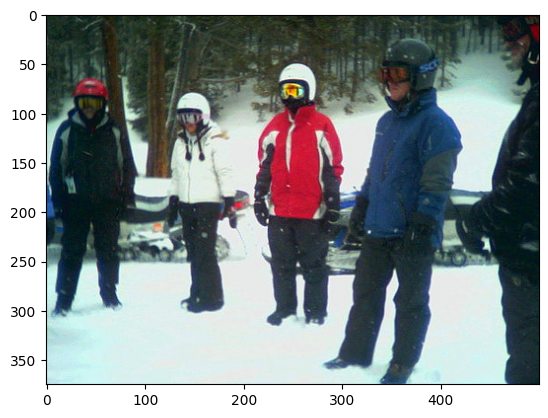

In [54]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

x = 3
pic_val = list(encoding_val.keys())[x]

val_content[pic_val]


reference = val_content[pic_val]


e = encoding_val[pic_val].reshape(1,2048)

x=plt.imread(images+pic+'.jpg')

plt.imshow(x)

caption = greedySearch(e)
print("Greedy Search Caption:",caption)
print()
print('Reference 1:',reference)

print()
print('BLEU-1:', round(sentence_bleu(reference, caption),3))

Greedy Search Caption: a man in a black shirt is playing a guitar

Reference 1: ['there is a woman and man wearing orange shirts playing instruments with sheet paper in front of them ', 'a cello player is playing during a concert ', 'a woman in a red shirt playing the cello ', 'a female playing a song on her violin ', 'a woman in a red shirt plays a cello ']

BLEU-1: 0.715


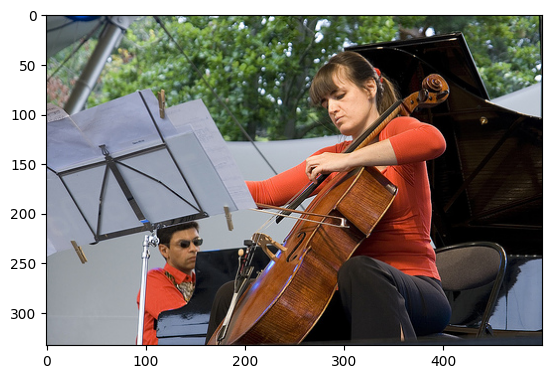

In [55]:
#1029450589
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

x = 14
pic_val = list(encoding_val.keys())[x]

val_content[pic_val]


reference = val_content[pic_val]


e = encoding_val[pic_val].reshape(1,2048)

x=plt.imread(images+pic_val+'.jpg')

plt.imshow(x)

caption = greedySearch(e)
print("Greedy Search Caption:",caption)
print()
print('Reference 1:',reference)

print()
print('BLEU-1:', round(sentence_bleu(reference, caption),3))

In [56]:
pics_val = list(encoding_val.keys())

In [57]:
acc_val = 0
for i in range(len(pics_val)):
    reference = val_content[pics_val[i]]
    e = encoding_val[pics_val[i]].reshape(1,2048)
    caption = greedySearch(e)
    acc_val += round(sentence_bleu(reference, caption),3)

In [58]:
print(len(pics_val))

1014


In [60]:
print(acc_val/1014)

0.5629753451676535


In [65]:
from tabulate import tabulate

# Example data: dataset types and BLEU accuracy scores
data = [
    ["Validation", acc_val/1014],
    ["Testing", acc/1000]
]

# Define column headers
headers = ["Dataset Type", "BLEU Accuracy Score"]

# Display the table using tabulate
table = tabulate(data, headers=headers, tablefmt="grid")

# Print the table
print(table)


+----------------+-----------------------+
| Dataset Type   |   BLEU Accuracy Score |
+================+=======================+
| Validation     |              0.562975 |
+----------------+-----------------------+
| Testing        |              0.563935 |
+----------------+-----------------------+
